[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [13]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [18]:
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path="../module-2/studio/.env", override=True)

True

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

## Messages as state

First, let's define some messages.

In [20]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [21]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm.invoke(messages)

AIMessage(content='In addition to whales, there are several other fascinating ocean mammals you might want to learn about:\n\n1. **Dolphins**: Highly intelligent and social creatures, dolphins are known for their playful behavior and are found in oceans worldwide.\n\n2. **Porpoises**: Often confused with dolphins, porpoises are smaller, have different-shaped teeth, and tend to be shyer and less acrobatic.\n\n3. **Seals**: These pinnipeds are known for their adaptability to both land and sea. There are two main groups: true seals and eared seals (like sea lions).\n\n4. **Sea Lions**: Often seen as the "showmen" of the pinniped world, sea lions are social and can often be seen interacting with each other on beaches and rocks.\n\n5. **Walruses**: Known for their distinctive tusks and whiskers, walruses live in Arctic regions and are heavily associated with the ice.\n\n6. **Manatees and Dugongs**: Often referred to as "sea cows," these gentle herbivores are found in warm coastal waters, an

We can run our chat model in a simple graph with `MessagesState`.

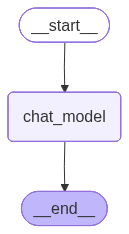

In [22]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other fascinating ocean mammals you might want to learn about:

1. **Dolphins**: These are highly intelligent and social animals known for their playful behavior and complex communication. There are various species, including the bottlenose dolphin and the orca, which is also known as the killer whale.

2. **Porpoises**: Similar in appearance to dolphins, porpoises tend to be smaller and have different shaped bodies and teeth. They are also less acrobatic than dolphins.

3. **Seals and Sea Lions (Pinnipeds)**: These include various species like the harbor seal, the norther

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

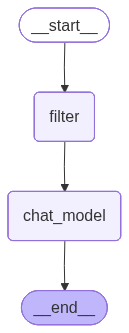

In [24]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other fascinating ocean mammals you can explore:

1. **Dolphins**: Known for their intelligence and playfulness, there are various species like the bottlenose dolphin and the orca, which is technically a type of dolphin.

2. **Porpoises**: Similar to dolphins but generally smaller and stouter, with differences in their teeth and fin shapes.

3. **Seals and Sea Lions**: These are pinnipeds and are known for their agility in water. Seals have smaller flippers and move on land in a wriggling motion, whereas sea lions have larger flippers and can "walk" on land.

4. **Walruses

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

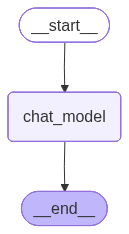

In [26]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [27]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [28]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other fascinating ocean mammals you can explore:

1. **Dolphins**: Known for their intelligence and playfulness, there are various species like the bottlenose dolphin and the orca, which is technically a type of dolphin.

2. **Porpoises**: Similar to dolphins but generally smaller and stouter, with differences in their teeth and fin shapes.

3. **Seals and Sea Lions**: These are pin

In [29]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other fascinating ocean mammals you can explore:

1. **Dolphins**: Known for their intelligence and playfulness, there are various species like the bottlenose dolphin and the orca, which is technically a type of dolphin.

2. **Porpoises**: Similar to dolphins but generally smaller and stouter, with differences in their teeth and fin shapes.

3. **Seals and Sea Lions**: These are pin

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

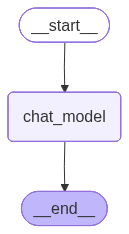

In [30]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [32]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [33]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r

# TWEAKS


In [ ]:
conversation_log = [
    {"role": "user", "content": "Hi! Could you briefly explain the highlights of this file?"},
    {"role": "assistant", "content": "Sure! Here’s a concise breakdown of the main insights."},
    {"role": "user", "content": "There’s a known alert that may trigger under some cases."},
    {"role": "assistant", "content": "Got it — I’ll flag that for revision."},
    {"role": "user", "content": "Perfect. Let’s also add a note for Aviral and Shambhavi."},
]

def crop_chat_history(chat_log, keep=3):
    """Keeps the most recent `keep` messages."""
    return chat_log[-keep:] if len(chat_log) > keep else chat_log

shortened = crop_chat_history(conversation_log, keep=3)
print("Shortened chat history:")
for msg in shortened:
    print(f"{msg['role'].upper()}: {msg['content']}")


def omit_messages(chat_log, forbidden_words):
    """Exclude any messages containing certain words."""
    return [m for m in chat_log if not any(fw.lower() in m['content'].lower() for fw in forbidden_words)]

filtered_history = omit_messages(conversation_log, ["alert", "error"])
print("\nFiltered chat (removed 'alert' and 'error'):")
for msg in filtered_history:
    print(f"{msg['role'].upper()}: {msg['content']}")

def clean_and_crop(chat_log, forbidden_words=None, keep=3):
    """Applies filtering and trimming sequentially."""
    if forbidden_words:
        chat_log = omit_messages(chat_log, forbidden_words)
    return crop_chat_history(chat_log, keep)

final_chat = clean_and_crop(conversation_log, forbidden_words=["alert"], keep=2)
print("\nFinal processed chat:")
for msg in final_chat:
    print(f"{msg['role'].upper()}: {msg['content']}")


Shortened chat history:
USER: There’s a known alert that may trigger under some cases.
ASSISTANT: Got it — I’ll flag that for revision.
USER: Perfect. Let’s also add a note for Dev and Neha.

Filtered chat (removed 'alert' and 'error'):
USER: Hi! Could you briefly explain the highlights of this file?
ASSISTANT: Sure! Here’s a concise breakdown of the main insights.
ASSISTANT: Got it — I’ll flag that for revision.
USER: Perfect. Let’s also add a note for Dev and Neha.

Final processed chat:
ASSISTANT: Got it — I’ll flag that for revision.
USER: Perfect. Let’s also add a note for Dev and Neha.
